Delta x = 0.01 Delta t = 0.0025 C = 25.0
Optimal Alarm Position: 0.000


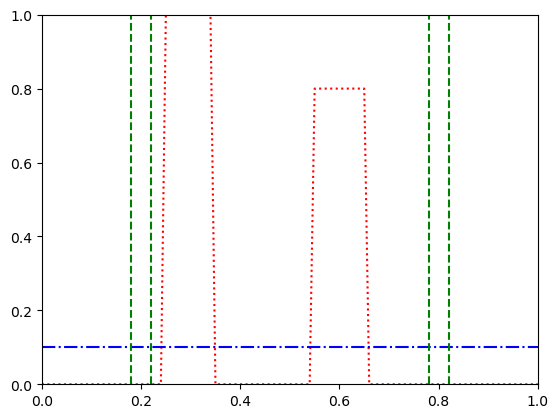

In [7]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

# ------------------------------------------------------------------------------------------

# Initial condition
def I2(x, a, b):
    return np.where((x >= a) & (x <= b), 1, 0)

# Exact solution
def U_exact(x,t,d):
    M = np.size(x)
    u_ex = d * np.ones(M)  
    for s in range(1, 1000, 2): # use the first 1000 terms (half of which are zero)
        npi = s * np.pi  # calculating multiple of pi
        c_n = (2 / npi) * (np.sin(npi * (0.5 + d / 2)) - np.sin(npi * (0.5 - d / 2)))                          
        u_ex = u_ex + c_n * np.cos(npi * x) * np.exp(-1 * npi * npi * t)
    return u_ex

# ------------------------------------------------------------------------------------------

class gas_can:
    def __init__(self, loc, radius, concentration):
        self.loc = loc                            # Central location of the canister
        self.radius = radius                      # Radius of the canister
        self.lower_bound = loc - radius           # Lower bound of the canister
        self.upper_bound = loc + radius           # Upper bound of the canister
        self.concentration = concentration        # Initial concentration in the canister

    def get_initial_concentration(self, x):
        # Set initial concentration within the canister bounds, else 0
        return np.where((x >= self.lower_bound) & (x <= self.upper_bound), self.concentration, 0)

# List of gas canisters
canisters = [
    gas_can(loc=0.3, radius=0.05, concentration=1.0),
    gas_can(loc=0.6, radius=0.05, concentration=0.8)
]

# ------------------------------------------------------------------------------------------

class scrubber():
    def __init__(self, loc, radius, efficiency, cap):
        self.loc = loc
        self.radius = radius
        self.lower_bound = self.loc - self.radius
        self.upper_bound = self.loc + self.radius   
        self.efficiency = efficiency                # Efficiency of the scrubber to absorb gas
        self.cap = cap                              # Maximum concentration that can be absorbed
        self.current_load = 0                       # Current concentration absorbed so far


# List of scrubbers 
scrubbers = [
    scrubber(loc=0.8, radius=0.02, efficiency=0.80, cap=5.0),
    scrubber(loc=0.2, radius=0.02, efficiency=0.60, cap=5.0)
]

# ------------------------------------------------------------------------------------------

# Setting parameters

# Time
Nt_gaps = 200  # Number of timesteps
T = 0.5  # Final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0., T, Nt_points)  # Times at each time step

# Space
Nx_spaces = 100  # Number of spaces in x
L = 1 # Length of interval
Nx_points = Nx_spaces + 1
x = np.linspace(0, L, Nx_points)  # Mesh points in space

dx = x[1] - x[0] 
dt = t[1] - t[0]

C = dt / (dx**2)
print("Delta x =", dx, "Delta t =", dt, "C =", C)

# Set up structures to hold U and U_ex2 and interim arrays
u = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)
U = np.zeros((Nx_points, Nt_points))
U_ex2 = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
A = np.zeros((Nx_points, Nx_points))
p = np.zeros(Nx_points)

# ------------------------------------------------------------------------------------------

# Set up the matrix A
for i in range(1, Nx_points - 1):  # Rows from 1 to Nx-2
    A[i, i - 1] = -C
    A[i, i + 1] = -C
    A[i, i] = 1 + 2 * C

# Implement Neumann BC
A[0, 0] = 1 + 2 * C
A[0, 1] = -2 * C
A[Nx_points - 1, Nx_points - 1] = 1 + 2 * C
A[Nx_points - 1, Nx_points - 2] = -2 * C

# ------------------------------------------------------------------------------------------

# Set the initial concentration profile based on multiple gas canisters
u_old = np.zeros(Nx_points)  # Initialize the concentration to zero everywhere

# Loop through each gas canister and add its contribution to `u_old`
for canister in canisters:
    u_old += canister.get_initial_concentration(x)

# Initialize matrices U and U_ex2 for first time step
U[:, 0] = u_old[:]

# Initialize `U_ex2` to zero for the exact solution
U_ex2[:, 0] = np.zeros(Nx_points)

# Loop through each canister and add its exact solution contribution to `U_ex2`
for canister in canisters:
    U_ex2[:, 0] += U_exact(x, 0, canister.radius)


# ------------------------------------------------------------------------------------------

# Define threshold concentration for the alarm
C0 = 1.0  # Initial concentration
threshold = C0 / 100  # Alarm should activate at concentration 1/100 of C0
optimal_alarm_position = None  # To store the optimal alarm position

# ------------------------------------------------------------------------------------------

# Perform time-stepping
for n in range(1, Nt_points):  # timestep from 1 to t = T-1 so last step finishes on t=T
    
    # Compute right-hand side `p`
    p[:] = u_old[:]

    # Initialize a copy of the diffusion matrix A for this time step
    A_total = A.copy()

    # Iterate over each scrubber and modify the diagonal of A_total
    for scrubber in scrubbers:
         
        # Get the affected indices for this scrubber
        affected_indices = np.where((x >= scrubber.lower_bound) & (x <= scrubber.upper_bound))[0]

        # Update the diagonal of A_total for each affected index
        for ii in affected_indices:
            A_total[ii, ii] += scrubber.efficiency  # Reduce the diagonal to represent the sink effect

        # Faster implementation below?
        # affected_indices = np.where((x >= scrubber.lower_bound) & (x <= scrubber.upper_bound))[0]
        # A_total[affected_indices, affected_indices] += scrubber.efficiency

    # Solve the linear system A_total * u = p
    u[:] = np.linalg.solve(A_total, p)

    # Update u_old before next step
    u_old = u.copy()
    U[:, n] = u

    # Update the exact solution `U_ex2` for each time step
    # U_ex2[:, n] = np.zeros(Nx_points)  # Initialize to zero for each time step
    # for canister in canisters:
        # U_ex2[:, n] += U_exact(x, t[n], canister.radius)

    # Find the optimal position for the alarm at this time step
    for i in range(Nx_points):
        if U[i, n] <= threshold:
            # Update the optimal alarm position if the current position is further from the container
            if optimal_alarm_position is None or abs(x[i] - 0.5) > abs(optimal_alarm_position - 0.5):
                optimal_alarm_position = x[i]

# ------------------------------------------------------------------------------------------

# Print the optimal alarm position
print(f"Optimal Alarm Position: {optimal_alarm_position:.3f}")

# set up animation plots
fig, ax = plt.subplots()
ax.axis([0,1,0,1])
def animate(i):
    l.set_data(x, U[:,i])
    m.set_data(x, U_ex2[:,i])
    
ax.axis([0,1,0,1.0])
l, = ax.plot([],[],':r')
m, = ax.plot([],[],'-.b')

# Plot vertical lines for the scrubber bounds
for scrubber in scrubbers:
    ax.axvline(x=scrubber.lower_bound, color='g', linestyle='--', label='Scrubber Bounds' if scrubber == scrubbers[0] else "")
    ax.axvline(x=scrubber.upper_bound, color='g', linestyle='--')

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt_points)

from IPython.display import HTML
HTML(ani2.to_jshtml())